In [1]:
from mesmerize import Transmission
from mesmerize.analysis.math.emd import emd_1d

from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

t = Transmission.from_hdf5('/home/kushal/Sars_stuff/hier_all_promoters.ptrn')

t.df.columns

X = np.vstack(t.df._RFFT.values)[:, :500]
X.shape

X = np.log10(np.abs(X))

X += np.abs(X.min())

/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
td = np.vstack(t.df._NORMALIZE.values)

In [4]:
DM = pairwise_distances(X, metric=emd_1d, n_jobs=22)

TypeError: _save_dispatcher() missing 1 required positional argument: 'arr'

In [25]:
DM = np.load('/home/kushal/Sars_stuff/cell_types_distance_matrix_log_abs.npy')

### Silhouette score of:

1. KMeans of fft

2. Hier with euc of fft

3. Hier with emd of fft

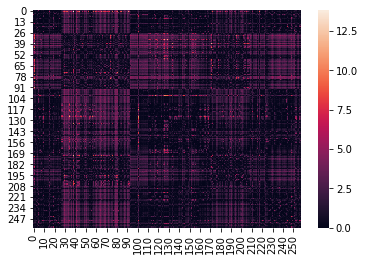

In [26]:
import seaborn as sns

sns.heatmap(DM)

In [7]:
from scipy.cluster.hierarchy import linkage, fcluster
from tqdm import tqdm

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from collections import OrderedDict

## Silhouette gives weird negative values

In [27]:
cluster_range = range(2, 15)

scores = OrderedDict.fromkeys(cluster_range)

# DM_S = DM + np.abs(DM.min())
# np.fill_diagonal(DM_S, 0)

for nc in tqdm(cluster_range):
    Z = linkage(DM, method='complete', optimal_ordering=False)
    labels = fcluster(Z, t=nc, criterion='maxclust')
    
    score = silhouette_score(DM, labels, metric='precomputed', n_jobs=22)
    
    scores[nc] = score

100%|██████████| 13/13 [00:00<00:00, 197.69it/s]


In [28]:
scores

OrderedDict([(2, 0.5884083456894647),
             (3, 0.3561385319500716),
             (4, 0.31651587857265046),
             (5, 0.015663133383296498),
             (6, -0.1160798279613993),
             (7, -0.3009424325924877),
             (8, -0.3413810953916057),
             (9, -0.3232121601266064),
             (10, -0.26660041876512763),
             (11, -0.2947254117493552),
             (12, -0.3153065105025543),
             (13, -0.3376113672979199),
             (14, -0.34494587953006456)])

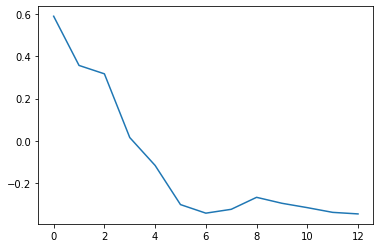

In [29]:
plt.plot(list(scores.values()))
# plt.xticks(list(scores.keys()))

In [30]:
import mesmerize
from mesmerize.analysis import clustering_metrics

### Was just tyring to figure out how to get the dbscore working with EMD

In [29]:
Z = linkage(DM, method='complete', optimal_ordering=True)
labels = fcluster(Z, t=7, criterion='maxclust')

radii = np.zeros(np.unique(labels).size)
centroids = np.zeros((np.unique(labels).size, X.shape[1]))


for i, c in enumerate(np.unique(labels)):
    members = np.take(X, np.where(labels == c)[0], axis=0)
    dist_m = pairwise_distances(members, metric=emd_1d, n_jobs=16)
    
    centroids[i, :], c_ix = clustering_metrics.get_centerlike(members, dist_matrix=dist_m)
    radii[i] = clustering_metrics.get_cluster_radius(members, dist_matrix=dist_m, centerlike_index=c_ix)

/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:46: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)


In [37]:
centroid_distances = pairwise_distances(centroids, metric=emd_1d, n_jobs=16)

centroid_distances[centroid_distances == 0] = np.inf
combined_intra_dists = radii[:, None] + radii



scores = np.max(np.nan_to_num(combined_intra_dists) / centroid_distances, axis=1)

In [7]:
Z = linkage(DM, method='complete', optimal_ordering=True)
labels = fcluster(Z, t=8, criterion='maxclust')
db_score = clustering_metrics.davies_bouldin_score(X, labels, metric=emd_1d)

/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:46: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)


[[1271.09917895  845.57381404  208.78761902 ...  598.43695257
   597.78451447  598.12986625]
 [ 822.19904158  697.54616495  551.57827842 ...  597.58328313
   596.65664733  597.74923302]
 [1775.29317257  838.70194664  667.60443513 ...  597.94313228
   597.91128165  595.77536864]
 ...
 [1027.19923699  680.94694422  693.64274965 ...  598.31780197
   598.23168967  597.77429238]
 [1292.93083788  720.8182536   547.66911056 ...  597.36285552
   599.46195011  597.90252317]
 [1338.85783639  474.73107568  611.86428108 ...  598.21142414
   596.64180988  598.80305529]]
[ 5.43649279  5.26870077  3.83137377  6.673156    6.40572078 18.023456
  0.          6.64262412]


In [8]:
db_score

6.535190529404915

# DB Score with EMD

In [31]:
cluster_range = range(2, 10)
scores = OrderedDict.fromkeys(cluster_range)

for nc in tqdm(cluster_range):
    Z = linkage(DM, method='complete', optimal_ordering=True)
    labels = fcluster(Z, t=nc, criterion='maxclust')
    
    score = clustering_metrics.davies_bouldin_score(X, labels, metric=emd_1d)
    
    scores[nc] = score

 75%|███████▌  | 6/8 [59:04<19:33, 586.51s/it]  /home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)
 88%|████████▊ | 7/8 [1:08:04<09:32, 572.56s/it]/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)
100%|██████████| 8/8 [1:16:27<00:00, 573.39s/it]


In [32]:
scores

OrderedDict([(2, (0.3950529190742267, array([0.39431441, 0.39579143]))),
             (3,
              (0.8979706826058399,
               array([0.78834115, 0.94245014, 0.96312075]))),
             (4,
              (1.6133834469819135,
               array([0.43515909, 2.5277977 , 2.52745625, 0.96312075]))),
             (5,
              (1.4510830564008066,
               array([0.43515909, 2.5277977 , 2.52745625, 0.84964538, 0.91535687]))),
             (6,
              (2.5061755453319603,
               array([0.52964606, 5.11013307, 5.10988128, 2.52239061, 0.84964538,
                      0.91535687]))),
             (7,
              (4.562800955165639,
               array([0.52964606, 5.11013307, 5.10988128, 2.52239061, 1.88619309,
                      8.38896041, 8.39240216]))),
             (8,
              (4.327299858086116,
               array([0.52964606, 5.11013307, 5.10988128, 3.54378272, 3.54359316,
                      0.        , 8.38896041, 8.39240216]))),

In [33]:
[s[0] for s in scores.values()]

[0.3950529190742267,
 0.8979706826058399,
 1.6133834469819135,
 1.4510830564008066,
 2.5061755453319603,
 4.562800955165639,
 4.327299858086116,
 4.444315069294222]

Text(0.5, 1.0, 'EMD DB Score, n_clusters is x + 2')

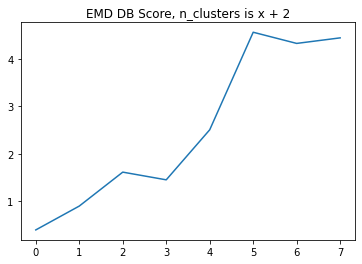

In [122]:
plt.plot([s[0] for s in scores.values()])
plt.title('EMD DB Score, n_clusters is x + 2')

In [51]:
from sklearn.decomposition import PCA, FastICA

# PCA space, label the clusters and cell types

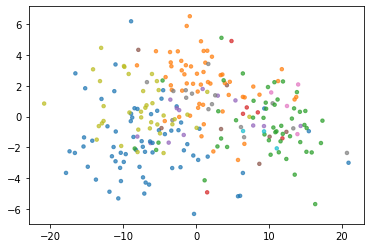

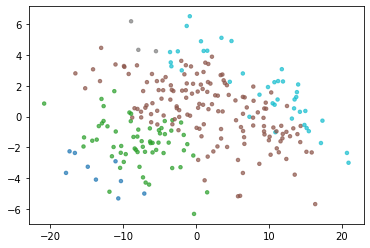

In [95]:
pca = PCA(n_components=2, svd_solver='full')

X_ = pca.fit_transform(X)

colors_column = 'cell_name'

colors = list(map(
    dict(
        zip(
            t.df[colors_column].unique(), 
            range(len(t.df[colors_column].unique()))
        )
    ).get, 
    t.df[colors_column]
))

Z = linkage(DM, method='complete', optimal_ordering=True)
labels = fcluster(Z, t=5, criterion='maxclust')

# colors = labels



plt.scatter(X_[:, 0], X_[:, 1], c=colors, s=12, alpha=0.7, cmap='tab10')
plt.show()
plt.scatter(X_[:, 0], X_[:, 1], c=labels, s=12, alpha=0.7, cmap='tab10')

## Eucledian DB score

In [35]:
from sklearn.metrics import davies_bouldin_score

In [41]:
cluster_range = range(2, 10)
scores_euc = OrderedDict.fromkeys(cluster_range)

DM_euc = pairwise_distances(X, n_jobs=22)

for nc in tqdm(cluster_range):
    Z = linkage(DM_euc, method='complete', optimal_ordering=True)
    labels = fcluster(Z, t=nc, criterion='maxclust')
    
    score = davies_bouldin_score(X, labels)
    
    scores_euc[nc] = score

  0%|          | 0/8 [00:00<?, ?it/s]/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
 38%|███▊      | 3/8 [00:00<00:00, 29.38it/s]/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously lik

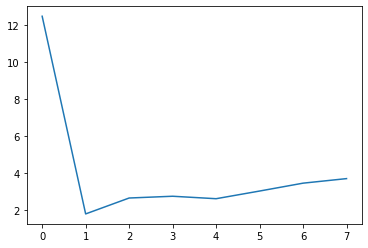

In [42]:
plt.plot([s for s in scores_euc.values()])

In [46]:
scores_euc.values()

odict_values([12.481453036112015, 1.811523745060285, 2.6698512419481597, 2.7653928530456424, 2.632271409036014, 3.0462673362480155, 3.471518611123811, 3.7171229083631516])

In [98]:
t.df.columns

Index(['CurvePath', 'ImgInfoPath', 'ImgPath', 'ImgUUID', 'ROI_State',
       'SampleID', 'anatomical_location', 'cell_name', 'comments', 'date',
       'dorso_ventral_axis', 'misc', 'morphology', 'promoter',
       'rostro_caudal_axis', 'stimulus_name', 'uuid_curve', '_RAW_CURVE',
       'meta', 'stim_maps', '_BLOCK_', '_SPLICE_ARRAYS', '_NORMALIZE', '_RFFT',
       '_ABSOLUTE_VALUE', '_LOG_TRANSFORM', 'FCLUSTER_LABELS'],
      dtype='object')

In [97]:
t.df.cell_name.unique()

array(['pnin', 'cesa-pos', 'palp', 'atena', 'pr', 'amg', 'ddn', 'pr_rn',
       'eminens', 'rten', 'atenp', 'antenal_relay', 'vac_in',
       'pr_tract_interneuron', 'ependymal', 'pbv_pnin', 'hnk1-pos',
       'dcen', 'cor_ass_bvin', 'pr_amg', 'mn'], dtype=object)

# Neuronal cells only

In [104]:
df_neuronal = t.df[~t.df.cell_name.isin(['cesa-pos', 'hnk1-pos', 'ependymal'])]
df_neuronal.cell_name.unique()

array(['pnin', 'palp', 'atena', 'pr', 'amg', 'ddn', 'pr_rn', 'eminens',
       'rten', 'atenp', 'antenal_relay', 'vac_in', 'pr_tract_interneuron',
       'pbv_pnin', 'dcen', 'cor_ass_bvin', 'pr_amg', 'mn'], dtype=object)

In [105]:
X_n = np.vstack(df_neuronal._RFFT.values)[:, :500]
X_n.shape

X_n = np.log10(np.abs(X_n))

X_n += np.abs(X_n.min())

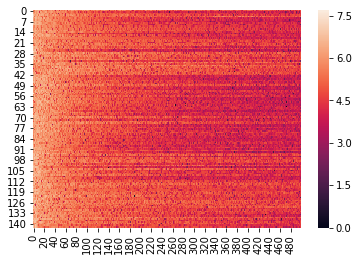

In [106]:
sns.heatmap(X_n)

In [107]:
DM_n = pairwise_distances(X_n, metric=emd_1d, n_jobs=22)

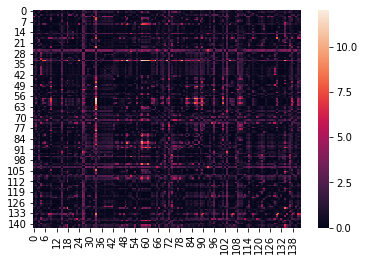

In [108]:
sns.heatmap(DM_n)

In [114]:
cluster_range = range(2, 10)
scores_neuronal = OrderedDict.fromkeys(cluster_range)

for nc in tqdm(cluster_range):
    Z = linkage(DM_n, method='complete', optimal_ordering=True)
    labels = fcluster(Z, t=nc, criterion='maxclust')
    
    score = clustering_metrics.davies_bouldin_score(X_n, labels, metric=emd_1d)
    
    scores_neuronal[nc] = score

  0%|          | 0/8 [00:00<?, ?it/s]/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)
 12%|█▎        | 1/8 [06:48<47:42, 408.94s/it]/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)
 25%|██▌       | 2/8 [13:02<39:50, 398.47s/it]/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)
 38%|███▊      | 3/8 [18:39<31:39, 379.80s/it]/home/kushal/repos/MESmerize/mesmerize/analysis/clustering_metrics.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ra = np.sum(dist_matrix[c_ix, :]) / (cluster_members.shape[0] - 1)
 50%|█████   

Text(0.5, 1.0, 'EMD DB Score Neuronal only, n_clusters is x + 2')

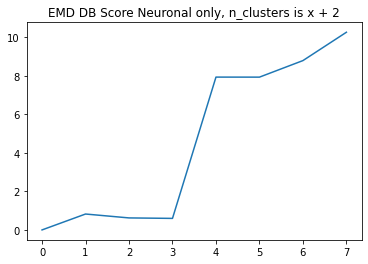

In [121]:
plt.plot([s[0] for s in scores_neuronal.values()])
plt.title('EMD DB Score Neuronal only, n_clusters is x + 2')

In [116]:
[s[0] for s in scores_neuronal.values()]

[0.0,
 0.8249710077405265,
 0.6228331461431775,
 0.5983259563647111,
 7.933087238804085,
 7.931332452436897,
 8.790134577348898,
 10.261851503630991]

# Euc neuronal

In [117]:
cluster_range = range(2, 10)
scores_neuronal_euc = OrderedDict.fromkeys(cluster_range)

DM_n_euc = pairwise_distances(X, n_jobs=22)

for nc in tqdm(cluster_range):
    Z = linkage(DM_n_euc, method='complete', optimal_ordering=True)
    labels = fcluster(Z, t=nc, criterion='maxclust')
    
    score = davies_bouldin_score(X, labels)
    
    scores_neuronal_euc[nc] = score

  0%|          | 0/8 [00:00<?, ?it/s]/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
 38%|███▊      | 3/8 [00:00<00:00, 28.20it/s]/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously lik

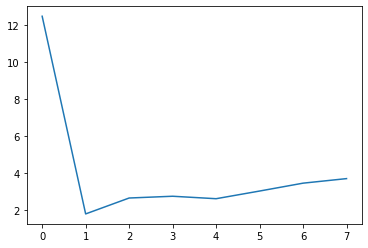

In [120]:
plt.plot(list(scores_neuronal_euc.values()))